Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.7546
Validation Loss: 0.6054, Validation Accuracy: 0.7356

Epoch 2/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.3070
Validation Loss: 0.4936, Validation Accuracy: 0.8161

Epoch 3/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.1636
Validation Loss: 0.5287, Validation Accuracy: 0.7471

Epoch 4/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.0878
Validation Loss: 0.4330, Validation Accuracy: 0.8161

Epoch 5/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.0553
Validation Loss: 0.5053, Validation Accuracy: 0.7701

Epoch 6/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.0365
Validation Loss: 0.4890, Validation Accuracy: 0.8046

Epoch 7/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.0282
Validation Loss: 0.5151, Validation Accuracy: 0.7816

Epoch 8/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.0203
Validation Loss: 0.4963, Validation Accuracy: 0.7816

Epoch 9/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.0144
Validation Loss: 0.5081, Validation Accuracy: 0.7931

Epoch 10/10


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training Loss: 0.0119
Validation Loss: 0.5071, Validation Accuracy: 0.7931


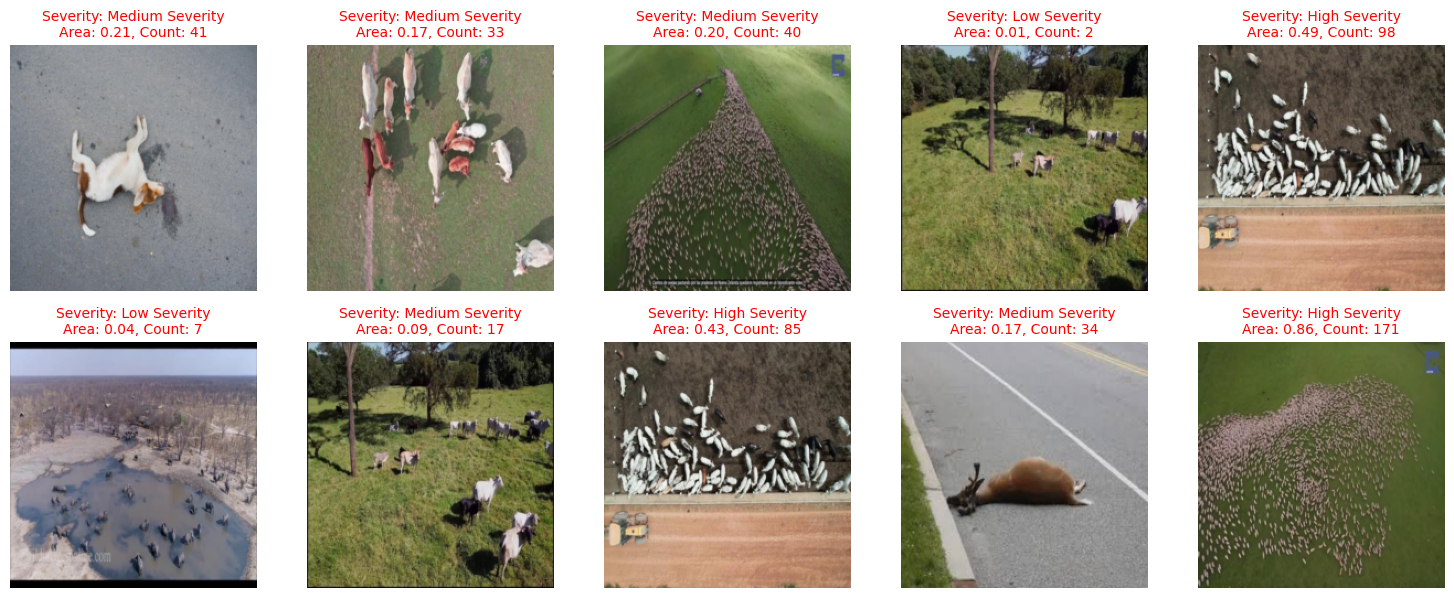

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification
from tqdm.notebook import tqdm

# Paths
train_dir = "/kaggle/input/animals-yolo/train/images"
train_labels_dir = "/kaggle/input/animals-yolo/train/labels"
val_dir = "/kaggle/input/animals-yolo/valid/images"
val_labels_dir = "/kaggle/input/animals-yolo/valid/labels"
test_dir = "/kaggle/input/animals-yolo/test/images"
test_labels_dir = "/kaggle/input/animals-yolo/test/labels"

# Reference height for scaling
reference_height = 500

# Severity classification based on area
def classify_severity(area):
    if area <= 0.05:
        return 0  # Low Severity
    elif 0.051 <= area < 0.25:
        return 1  # Medium Severity
    else:
        return 2  # High Severity

# Custom Dataset with Area and Count Calculation
class AnimalSeverityDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.image_paths = glob.glob(f"{images_dir}/*.jpg") + glob.glob(f"{images_dir}/*.png")
        self.labels_dir = labels_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = os.path.join(self.labels_dir, os.path.basename(img_path).replace('.jpg', '.txt').replace('.png', '.txt'))

    # Load image and calculate scaling factor
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size
        scaling_factor = orig_height / reference_height

    # Assumption: average area occupied by a single animal (based on prior knowledge or dataset analysis)
        avg_area_per_animal = 0.005  # Adjust this value based on dataset characteristics

    # Process label file to compute bounding box areas and estimated counts
        total_area = 0
        estimated_count = 0
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                _, _, _, width, height = map(float, line.strip().split())
                width *= scaling_factor
                height *= scaling_factor
                bbox_area = width * height
                total_area += bbox_area
                estimated_count += max(1, int(bbox_area / avg_area_per_animal))  # Ensure at least 1 animal per box

    # Classify severity based on area
        severity = classify_severity(total_area)

        if self.transform:
            image = self.transform(image)

        return image, severity, total_area, estimated_count  # Return estimated count


# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

# Datasets and DataLoaders
train_data = AnimalSeverityDataset(images_dir=train_dir, labels_dir=train_labels_dir, transform=transform)
val_data = AnimalSeverityDataset(images_dir=val_dir, labels_dir=val_labels_dir, transform=transform)
test_data = AnimalSeverityDataset(images_dir=test_dir, labels_dir=test_labels_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=3,
    ignore_mismatched_sizes=True
).to(device)

# Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

# Training Function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels, _, _ in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Validation Function
def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels, _, _ in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Display Function with Count and Area
def display_images_with_metadata(images, labels, areas, counts, severity_labels, num_images=10):
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(images))):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        label = labels[i].item()
        area = areas[i]
        count = counts[i]
        
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Severity: {severity_labels[label]}\nArea: {area:.2f}, Count: {count}", fontsize=10, color='red')
    plt.tight_layout()
    plt.show()

# Testing and Display
test_images, test_labels, test_areas, test_counts = next(iter(test_loader))
severity_labels = ['Low Severity', 'Medium Severity', 'High Severity']
display_images_with_metadata(test_images, test_labels, test_areas, test_counts, severity_labels)


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test Accuracy: 0.6744
Test Precision (weighted): 0.6744


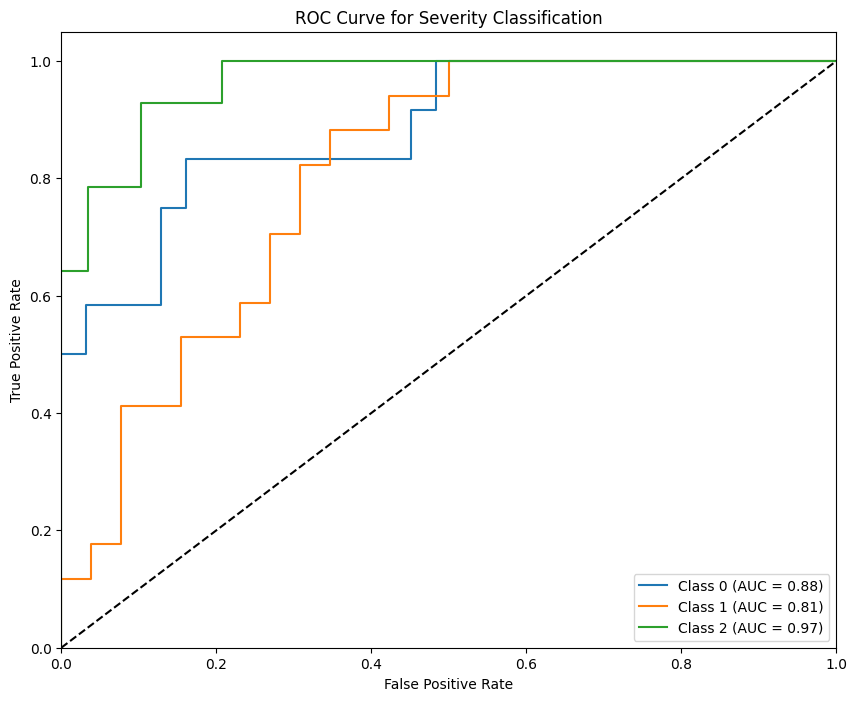

Average Precision for Class 0: 0.8154
Average Precision for Class 1: 0.7015
Average Precision for Class 2: 0.9384
Mean Average Precision (mAP): 0.8184


In [5]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Updated Test Function with ROC Curve, Accuracy, Precision, and mAP
def test_model_with_metrics_and_map(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels, _, _ in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)

            # Collecting all labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate Accuracy and Precision
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision (weighted): {precision:.4f}")

    # ROC Curve and AUC for each class
    plt.figure(figsize=(10, 8))
    for i in range(3):  # Assuming three classes for severity
        fpr, tpr, _ = roc_curve([1 if label == i else 0 for label in all_labels],
                                [prob[i] for prob in all_probs])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    # Plotting the ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Severity Classification")
    plt.legend(loc="lower right")
    plt.show()

    # Calculate Average Precision (AP) for each class and Mean Average Precision (mAP)
    ap_scores = []
    for i in range(3):
        binary_labels = [1 if label == i else 0 for label in all_labels]
        class_probs = [prob[i] for prob in all_probs]
        ap = average_precision_score(binary_labels, class_probs)
        ap_scores.append(ap)
        print(f"Average Precision for Class {i}: {ap:.4f}")

    # Mean Average Precision (mAP)
    mAP = np.mean(ap_scores)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Run the test with metrics and mAP
test_model_with_metrics_and_map(model, test_loader, device)


In [6]:
import torch
import os

# Define your model save path with .pt extension
model_save_path = "/kaggle/working/models/animal_severity_model.pt"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /kaggle/working/models/animal_severity_model.pt
